In [103]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn, gamma
from scipy.misc import derivative
from scipy.integrate import nquad
import camb
from camb import model, initialpower

In [121]:
## cosmology WMAP9
h = 0.7
H0 = h*100
oc = 0.236
ob = 0.046
om = ob+oc
ol = 1-om#0.718
ns = 0.9646
s8 = 0.817
#betaD = finterp(0.0)/bD
## test array
PI_arr=logspace(-0.5, 1, 50)
rp_arr = [1.0, 2.0, 5.0, 10.0, 20.0, 40.0]

In [105]:
### power spectrum from camb
zarr = linspace(0,2,5)
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=ob*h**2, omch2=om*h**2)#omch2=oc*h**2)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=zarr, kmax=100.0)
results = camb.get_results(pars)
########### NL power spectrum ########
pars.NonLinear = model.NonLinear_both
#pars.NonLinear = model.NonLinear_none  #linear
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100.0, npoints = 150)
#savetxt('kh_Pk_linear.txt',array([kh_nonlin, pk_nonlin[0]]).T)

Note: redshifts have been re-sorted (earliest first)


In [107]:
Pmatter_z0_interp = interpolate.interp1d(log(kh_nonlin), pk_nonlin[0],fill_value='extrapolate')
Pmatter_z0 = lambda k: Pmatter_z0_interp(log(k))

In [120]:
################# long brute force compute
nbin=501 ## similar answer between 500-5000 bins
kabs = lambda kz, kp: sqrt(kz**2+kp**2)

#xi_gp = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter2(kabs(kz,kp),z)*jn(2,kp*rp)*(1.0+betaD*kz**2/(kp**2+kz**2))
xi_gp = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter_z0(kabs(kz,kp))*jn(2,kp*rp)

ik = logspace(-4, 2,nbin)
dk = ik[1:]-ik[:-1]
ikc = 0.5*(ik[1:]+ik[:-1])
kz, kp = array(meshgrid(ikc,ikc)).reshape(2,-1)
dkz, dkp = array(meshgrid(dk,dk)).reshape(2,-1)

def xi_int (rp, PI, z=0):
    xi_arr = xi_gp(kz,kp,rp,PI,z)
    out = sum(xi_arr*dkz*dkp)
    return out

brute_arr = array([[xi_int(irp, iPI) for iPI in PI_arr] for irp in rp_arr])

In [108]:
## 2/14-3/5 try marko's fft method for k*Pk
kk2=kh_nonlin
kPk = pk_nonlin[0]*kh_nonlin
#kk2 = logspace(-4,1,Nk)
#kPk = kk2*Pmatter_z0(kk2)
Nk=len(kPk) ## number of bins
kPk_fft = fft(kPk) ## FFT
klogstep = log(kk2[1]/kk2[0])
#print klogstep

########## now compare how accurate marko's integration is
kmin,kmax=kk2[[0,-1]]
ifreq = fftfreq(Nk)##
nu_arr = 1j*2*pi*fftfreq(Nk, d=klogstep) ## the argument goes into k^nu_n, now nu_n is nu_arr
cn = kPk_fft*kmin**(-nu_arr) ## the fourier coefficients

############# test inverse fft
#dfreq = ifreq[1]-ifreq[0]
#kPk_ifft = array([sum(kPk_fft*exp(1j*2*pi*logk*ifreq))*dfreq for logk in arange(Nk)])
### because Pk = sum Pnu * exp(i 2pi logk nu) dnu

############## test marko method
### inverse FFT, has 1/N in it: http://mathworld.wolfram.com/DiscreteFourierTransform.html
kPk_marko = array([sum(cn*k**nu_arr)/Nk for k in kk2])

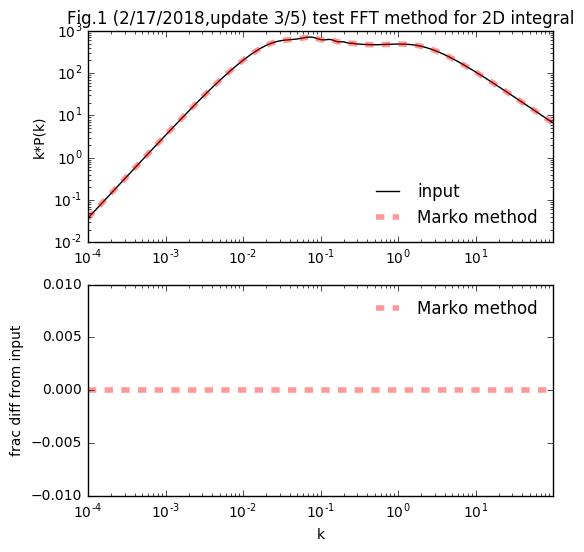

In [109]:
################## plotting  Marko fft test
f, (ax, ax2)=subplots(2,1,figsize=(6,6))
ax.plot(kk2, kPk,'k-',label='input')
#ax.plot(kk2, Pk_ifft, 'b-',lw=8,alpha=0.3, label='ifft(fft(Pk))')
ax.plot(kk2, real(kPk_marko),'r--',lw=4, alpha=0.4 , label='Marko method')
ax.set_xscale('log')
ax.set_ylabel('k*P(k)')
ax.set_yscale('log')
ax.legend(frameon=0,loc=0)
ax.set_title('Fig.1 (2/17/2018,update 3/5) test FFT method for 2D integral')
#ax2.plot(kk2, Pk_ifft/kPk-1, 'b-',lw=8, alpha=0.3, label='ifft(fft(Pk))')
ax2.plot(kk2, kPk_marko/kPk-1, 'r--',lw=4, alpha=0.4 ,label='Marko method')
ax2.set_xscale('log')
ax2.set_ylim(-0.01,0.01)
ax2.set_xlabel('k')
ax2.set_ylabel('frac diff from input')
ax2.legend(frameon=0,loc=0)
show()

In [116]:
def test_kbins(rp, PI, Nk=150):

    kk2 = logspace(-4,2,Nk)
    kPk = kk2*Pmatter_z0(kk2)
    Nk=len(kPk) ## number of bins
    kPk_fft = fft(kPk) ## FFT
    klogstep = log(kk2[1]/kk2[0])
    ## now compare how accurate marko's integration is
    kmin,kmax=kk2[[0,-1]]
    ifreq = fftfreq(Nk)##
    ## the argument goes into k^nu_n, now nu_n is nu_arr
    nu_arr = 1j*2*pi*fftfreq(Nk, d=klogstep) 
    cn = kPk_fft*kmin**(-nu_arr)
    fun_marko = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(2.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)/(1-nu**2)
    xi_int_marko = lambda rp, PI: sum(cn*fun_marko(rp, PI, nu_arr))/Nk
    return xi_int_marko(rp, PI)

for iNk in (50, 100, 150,200, 500,1000):
    print iNk,test_kbins(rp, PI, iNk)

50 (9.53238184053-0.00483682204855j)
100 (9.52995807538-0.00872545571788j)
150 (9.50331420174+0.0039801453379j)
200 (9.54340656057-0.00212400240301j)
500 (9.53656505352+0.000261184803206j)
1000 (9.53855384452-0.000281810797344j)


In [117]:
#fun_marko = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(3.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)*( (nu-3.0)*(rp**2+PI**2)+ (rp**2-(3+nu)*PI**2*betaD))/(nu-3.0)/(nu**2-1)
fun_marko = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(2.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)/(1-nu**2)
xi_int_marko = lambda rp, PI: sum(cn*fun_marko(rp, PI, nu_arr))/len(nu_arr)
marko_arr = array([[xi_int_marko(irp, iPI) for iPI in PI_arr] for irp in rp_arr])

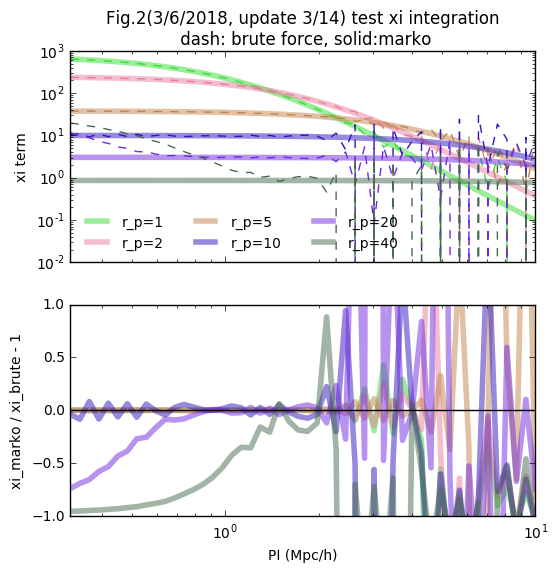

In [122]:
f,(ax,ax2)=subplots(2,1,sharex=True,figsize=(6,6))
i=0
seed(5)
for irp in rp_arr:
    icolor=rand(3)
    ax.plot(PI_arr,brute_arr[i],'--',color=icolor,)
    ax.plot(PI_arr,marko_arr[i],'-',lw=4, alpha=0.5,color=icolor,label='r_p=%i'%(irp))
    ax2.plot(PI_arr,marko_arr[i]/brute_arr[i]-1,'-',lw=4, alpha=0.5, color=icolor)
    i+=1
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(amin(PI_arr),amax(PI_arr))
ax2.set_xlabel('PI (Mpc/h)')
ax.set_ylabel('xi term')
ax2.set_ylabel('xi_marko / xi_brute - 1')
ax2.set_ylim(-1,1)
ax2.plot(PI_arr,zeros(len(PI_arr)),'k-')
ax.legend(frameon=0,fontsize=10,loc=0,ncol=3)
ax.set_title('Fig.2(3/6/2018, update 3/14) test xi integration\n dash: brute force, solid:marko')
show()